In [1]:
# Import packages 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import statsmodels.stats.multitest as smm
from pathlib import Path
from matplotlib.ticker import FixedFormatter, FixedLocator

# 1 Import Data

In [2]:
# Import DEG data 
deg_na = pd.read_csv('11_identify_DEG/deg_na.csv')
deg_nr = pd.read_csv('11_identify_DEG/deg_nr.csv')
deg_ar = pd.read_csv('11_identify_DEG/deg_ar.csv')

deg={'deg_na': deg_na, 'deg_nr': deg_nr, 'deg_ar': deg_ar}

# Import GO data 
# Geneid to GO term
goterm = pd.read_csv('14_functional_annotation/ccar2swissprotGO_long.txt', sep='\t') 
# GO term to description
godesc = pd.read_csv('14_functional_annotation/go_data.txt', sep='\t')
godesc.set_index('id', inplace=True)


# 2 GO go_na Analysis Output 

In [3]:
go_files = sorted(Path("14_functional_annotation").glob('deg_*_GOterms.csv'))

# total number of genes in the background dataset 
total_num_genes = pd.read_csv('12_gene_length_distribution/total_number_of_genes.csv', sep=',')

# create empty dict for df's
go_enriched = []


for f in go_files: 
    go_terms = pd.read_csv(f, sep=',')
    # strip emtpy space around GO terms 
    go_terms['category'] = go_terms['category'].str.strip()
    # since the term and ontology column are empty, I filled them with information from the godesc dataframe
    go_terms['term'] = godesc.loc[go_terms['category'], 'name'].to_numpy()
    go_terms['ontology'] = godesc.loc[go_terms['category'], 'namespace'].to_numpy()
    # calculate expected number in each category 
    go_terms['expectedDEInCat'] = (go_terms['numInCat']/len(total_num_genes))*len(deg[f.stem[:-8]])
    # calculate fold enrichment
    go_terms['foldEnrichment'] = (go_terms['numDEInCat']/go_terms['expectedDEInCat'])
    # calculate negative fold change from the FDR corrected values
    go_terms['-log10(FDR)'] = -np.log10(go_terms['over_represented_pvalue'])
    go_terms['padj'] = smm.multipletests(go_terms['over_represented_pvalue'], method='bonferroni')[1]
    go_terms['-log10(padj)'] = -np.log10(go_terms['padj'])
    go_terms = go_terms.sort_values(by='padj')
    go_terms = go_terms[go_terms['padj'] <= 0.05]#.iloc[-10:]
    if 'na' in f.name: 
        go_terms['comparison'] = 'Normoxia to Anoxia'
    elif 'nr' in f.name:
        go_terms['comparison'] = 'Normoxia to Reoxygenation'
    elif 'ar' in f.name:
        go_terms['comparison'] = 'Anoxia to Reoxygenation'
    
    # save to list 
    go_enriched.append(go_terms)
# merge the dataframes and add column with name of comparison
go = pd.concat(go_enriched)
go['log2(foldEnrichment)'] = np.log2(go['foldEnrichment'])
go.sort_values(by='log2(foldEnrichment)', ascending=False, inplace=True)


In [4]:
# Identification of redundant GO terms 
# export GO terms and padj values as import to Revigo
for comparison, data in go.groupby('comparison'):
    regivo = data[['category', 'padj']]
    regivo.to_csv(f'14_functional_annotation/1_for_regivo_input/go_{comparison}_to_revigo.csv', index=False, sep='\t')



In [5]:
# Output from Regivo
# Since I get three files for each comparison, I will merge them into one file
base_dir = Path('14_functional_annotation/2_regivo_output')

dfs = []

for subdir in base_dir.iterdir():
    if not subdir.is_dir():
        continue
    go_files = sorted(subdir.glob('Revigo_*_OnScreenTable.tsv'))
    for f in go_files:
        df = pd.read_csv(f, sep='\t')
        dfs.append(df)
    concatenated_df = pd.concat(dfs, ignore_index=True)
    # Define the output file path
    output_file = subdir / f"{subdir.name}_non_redundant_go_terms.csv"
    # Save the concatenated DataFrame to the output file
    concatenated_df.to_csv(output_file, index=False)

non_red_go = {'Normoxia to Anoxia': pd.read_csv('/home/maggy/WholeGenomeBisulphiteSequencing/RNAseq_pipeline/14_functional_annotation/2_regivo_output/NvsA/NvsA_non_redundant_go_terms.csv'),
              'Normoxia to Reoxygenation': pd.read_csv('/home/maggy/WholeGenomeBisulphiteSequencing/RNAseq_pipeline/14_functional_annotation/2_regivo_output/NvsR/NvsR_non_redundant_go_terms.csv'), 
              'Anoxia to Reoxygenation': pd.read_csv('/home/maggy/WholeGenomeBisulphiteSequencing/RNAseq_pipeline/14_functional_annotation/2_regivo_output/AvsR/AvsR_non_redundant_go_terms.csv')}

non_red = []

# Filter the go dataframe to only include the non-redundant GO terms
for comparison, data in go.groupby('comparison'):
    non_red.append(go[go['category'].isin(non_red_go[comparison]['TermID'])])
go = pd.concat(non_red)



<Axes: xlabel='ontology', ylabel='Count'>

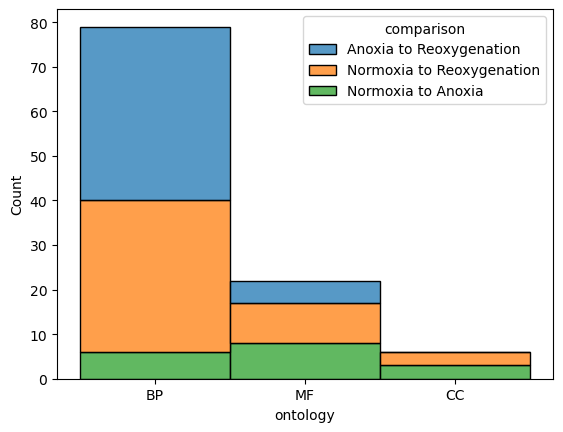

In [6]:
sns.histplot(data=go, x='ontology', hue='comparison', bins=10, multiple='stack')

In [7]:
# fo through go and keep only the top ten for each ontology 
go_for_plot=[]

for ontology, data in go.groupby('ontology'):
    for comparison, data in data.groupby('comparison'):
        temp = data.sort_values(by=['log2(foldEnrichment)', '-log10(padj)'], ascending=[False, True]).iloc[:10]
        go_for_plot.append(temp)
go = pd.concat(go_for_plot)


# 3 Plot

/home/maggy/anaconda3/envs/rnaseq/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/maggy/anaconda3/envs/rnaseq/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/home/maggy/anaconda3/envs/rnaseq/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


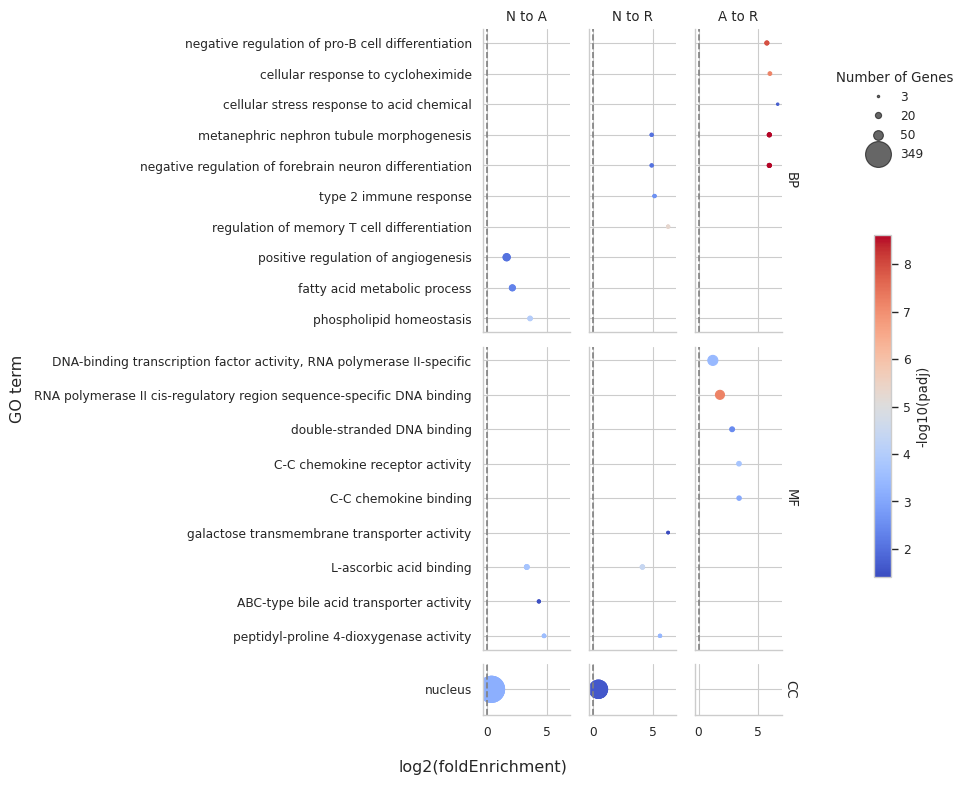

In [18]:
# define a function to acces the df in arrays 
def custum_scatterplot(data, norm, cmap, **kwargs):
    scatter = plt.scatter(x=data['log2(foldEnrichment)'], y=data['term'], c=data['-log10(padj)'], s=data["numDEInCat"], norm=norm, cmap=cmap)
    h, l = scatter.legend_elements(prop='sizes', alpha=0.6, num=FixedLocator([int(go['numDEInCat'].min()),20, 50,int(go['numDEInCat'].max())], nbins=5))
    handles.extend(h)
    labels.extend(l)
# needed for legend number of Genes 
handles, labels = [], []

# create color bar
norm = plt.Normalize(go['-log10(padj)'].min(), go['-log10(padj)'].max())
cmap = sns.color_palette(palette='coolwarm', as_cmap=True)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

# create a Facetgrid 3x3
sns.set_theme(style="whitegrid", palette="coolwarm", context='paper')
g = sns.FacetGrid(go, col='comparison', row ='ontology', sharey='row', sharex = True, gridspec_kws={'height_ratios':[3,3,0.5]}, 
                  col_order=['Normoxia to Anoxia', 'Normoxia to Reoxygenation', 'Anoxia to Reoxygenation'], row_order= ['BP', 'MF', 'CC' ], margin_titles=True)

# set size for fig 
g.figure.set_figwidth(25/2.54)
g.figure.set_figheight(20/2.54)
g.map_dataframe(custum_scatterplot, norm=norm, cmap=cmap)

# set title 
g.set_titles(template= '', col_template='', row_template='{row_name}')   
g.figure.supxlabel('log2(foldEnrichment)')
g.figure. supylabel('GO term')
g.axes_dict[('BP', 'Anoxia to Reoxygenation')].set_title('A to R')
g.axes_dict[('BP', 'Normoxia to Reoxygenation')].set_title('N to R')
g.axes_dict[('BP', 'Normoxia to Anoxia')].set_title('N to A')
g.refline(x=0)


# legend NUmber of Genes 
han = pd.Series(handles, index=labels)
han = han.loc[~han.index.duplicated(keep='first')]
han.index = han.index.str.replace('$\mathdefault{', '')
han.index = han.index.str.replace('}$', '')
han.index = han.index.astype(int)
han = han.sort_index(ascending=True)

legend = g.axes[0,2].legend(han.values, han.index, loc="upper left", title="Number of Genes", bbox_to_anchor=(1.5, 0.9), frameon=False)

# add color bar 
plt.colorbar(sm, label='-log10(padj)', use_gridspec=True, ax=g.axes, location='right', shrink=0.5, pad=-0.1, anchor=(0,0.4))

g.tight_layout()

